In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


In [23]:
df = pd.read_csv("../data/processed/carpredict_clean.csv")  # Replace with your actual file path

# Basic dataset information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
print(df.info())
print("\nBasic Statistics:")
print(df.describe())

Dataset Shape: (15364, 9)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15364 entries, 0 to 15363
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            15364 non-null  int64  
 1   transmission     15364 non-null  object 
 2   condition        15364 non-null  object 
 3   make             15364 non-null  object 
 4   model            15364 non-null  object 
 5   car_age          15364 non-null  int64  
 6   engine_info      15364 non-null  object 
 7   color            15174 non-null  object 
 8   mileage_imputed  15364 non-null  float64
dtypes: float64(1), int64(2), object(6)
memory usage: 1.1+ MB
None

Basic Statistics:
              price       car_age  mileage_imputed
count  1.536400e+04  15364.000000     1.536400e+04
mean   2.570792e+06     13.055194     1.118242e+05
std    2.632010e+06      3.883693     1.245230e+05
min    1.200000e+05      3.000000     0.000000e+00
25% 

In [24]:
print("First 10 rows:")
display(df.head(10))

# Check for missing values
print("\nMissing Values:")
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

# Check target variable distribution
print(f"\nTarget Variable (Price) Statistics:")
print(f"Mean: {df['price'].mean():,.0f}")
print(f"Median: {df['price'].median():,.0f}")
print(f"Min: {df['price'].min():,.0f}")
print(f"Max: {df['price'].max():,.0f}")

First 10 rows:


,price,transmission,condition,make,model,car_age,engine_info,color,mileage_imputed
0,2380000,Automatic,Foreign Used,Subaru,Legacy,10,Unknown,Silver,85644.0
1,1050000,Automatic,Foreign Used,Toyota,Sienta,11,1.5 FWD,Gray,98560.0
2,7000000,Automatic,Foreign Used,Toyota,Land Cruiser Prado,10,2.8 D-4d,White,56918.0
3,1950000,Automatic,Foreign Used,Toyota,Premio,10,1.8 FWD,Black,66000.0
4,920000,Automatic,Foreign Used,Toyota,Vitz,10,1.3 AWD 5dr,Silver,42308.0
5,1650000,Automatic,Kenyan Used,Toyota,Harrier,16,2.4,White,120589.0
6,6000000,Automatic,Foreign Used,Toyota,Land Cruiser Prado,11,2.7 VVT-i,Pearl,20000.0
7,2840000,Automatic,Kenyan Used,Bmw,X3,14,xDrive28i,Black,123000.0
8,1300000,Automatic,Foreign Used,Subaru,Impreza,10,Unknown,White,48565.0
9,930000,Automatic,Foreign Used,Toyota,Spade,11,1.5,Yellow,65300.0



Missing Values:
color    190
dtype: int64

Target Variable (Price) Statistics:
Mean: 2,570,792
Median: 1,790,000
Min: 120,000
Max: 37,049,000


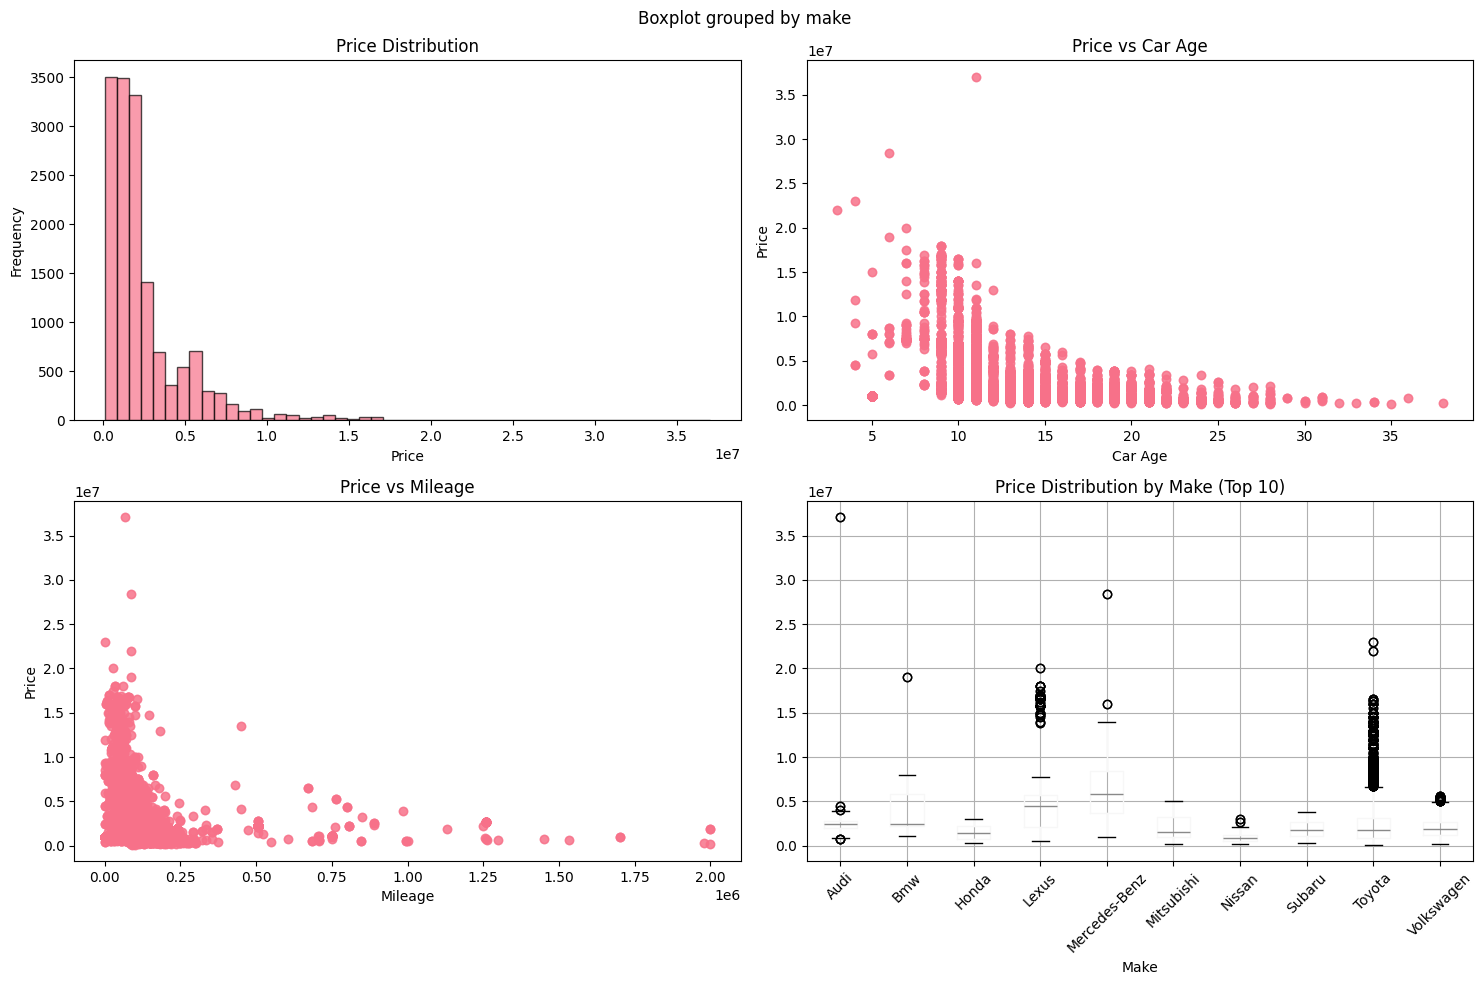

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Price distribution
axes[0, 0].hist(df['price'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Price Distribution')
axes[0, 0].set_xlabel('Price')
axes[0, 0].set_ylabel('Frequency')

# Price vs Car Age
axes[0, 1].scatter(df['car_age'], df['price'], alpha=0.6)
axes[0, 1].set_title('Price vs Car Age')
axes[0, 1].set_xlabel('Car Age')
axes[0, 1].set_ylabel('Price')

# Price vs Mileage
axes[1, 0].scatter(df['mileage_imputed'], df['price'], alpha=0.6)
axes[1, 0].set_title('Price vs Mileage')
axes[1, 0].set_xlabel('Mileage')
axes[1, 0].set_ylabel('Price')

# Price by Make (top 10)
top_makes = df['make'].value_counts().head(10).index
df_top_makes = df[df['make'].isin(top_makes)]
df_top_makes.boxplot(column='price', by='make', ax=axes[1, 1])
axes[1, 1].set_title('Price Distribution by Make (Top 10)')
axes[1, 1].set_xlabel('Make')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show();

In [33]:
outdir = "../outputs"

outpath = os.path.join(outdir, "price_v_other_feat.png")

# you can choose dpi, format, etc.
fig.savefig(outpath, dpi=300, format="png", bbox_inches="tight")

In [26]:
df_processed = df.copy()

# Handle missing values in color column (NULL -> 'Unknown')
df_processed['color'] = df_processed['color'].fillna('Unknown')

# Display unique values in categorical columns
categorical_cols = ['transmission', 'condition', 'make', 'model', 'engine_info', 'color']
print("Unique values in categorical columns:")
for col in categorical_cols:
    print(f"{col}: {df_processed[col].nunique()} unique values")
    if df_processed[col].nunique() <= 10:  # Show values if not too many
        print(f"  Values: {df_processed[col].unique()}")
    print()

Unique values in categorical columns:
transmission: 2 unique values
  Values: ['Automatic' 'Manual']

condition: 3 unique values
  Values: ['Foreign Used' 'Kenyan Used' 'Brand New']

make: 31 unique values

model: 184 unique values

engine_info: 569 unique values

color: 18 unique values



In [27]:
print("Creating additional features...")

# Extract engine size from engine_info
def extract_engine_size(engine_info):
    try:
        import re
        match = re.search(r'(\d+\.?\d*)', str(engine_info))
        if match:
            return float(match.group(1))
        else:
            return np.nan
    except:
        return np.nan

df_processed['engine_size'] = df_processed['engine_info'].apply(extract_engine_size)

# Create luxury brand indicator
luxury_brands = ['Bmw', 'Mercedes-Benz', 'Audi', 'Lexus', 'Infiniti', 'Acura']
df_processed['is_luxury'] = df_processed['make'].isin(luxury_brands).astype(int)

# Create price per km feature (avoid division by zero)
df_processed['price_per_km'] = df_processed['price'] / (df_processed['mileage_imputed'] + 1)

print(f"Engine size extracted. Non-null values: {df_processed['engine_size'].notna().sum()}")
print(f"Luxury brand indicator created. Luxury cars: {df_processed['is_luxury'].sum()}")

# Display new features
print("\nNew features created:")
print(df_processed[['engine_size', 'is_luxury', 'price_per_km']].describe())

Creating additional features...
Engine size extracted. Non-null values: 12116
Luxury brand indicator created. Luxury cars: 1368

New features created:
        engine_size     is_luxury  price_per_km
count  12116.000000  15364.000000  1.536400e+04
mean      45.576032      0.089039  2.866948e+03
std      208.779225      0.284810  1.462494e+05
min        1.000000      0.000000  1.099999e-01
25%        1.400000      0.000000  9.189065e+00
50%        2.000000      0.000000  1.756446e+01
75%        3.000000      0.000000  4.404657e+01
max     2400.000000      1.000000  1.190000e+07


Correlation Matrix:


,price,car_age,mileage_imputed,engine_size,is_luxury
price,1.0000,-0.3551,-0.1568,0.1154,0.1836
car_age,-0.3551,1.0000,0.3238,0.0400,-0.0354
mileage_imputed,-0.1568,0.3238,1.0000,-0.0299,-0.0497
engine_size,0.1154,0.0400,-0.0299,1.0000,0.2753
is_luxury,0.1836,-0.0354,-0.0497,0.2753,1.0000


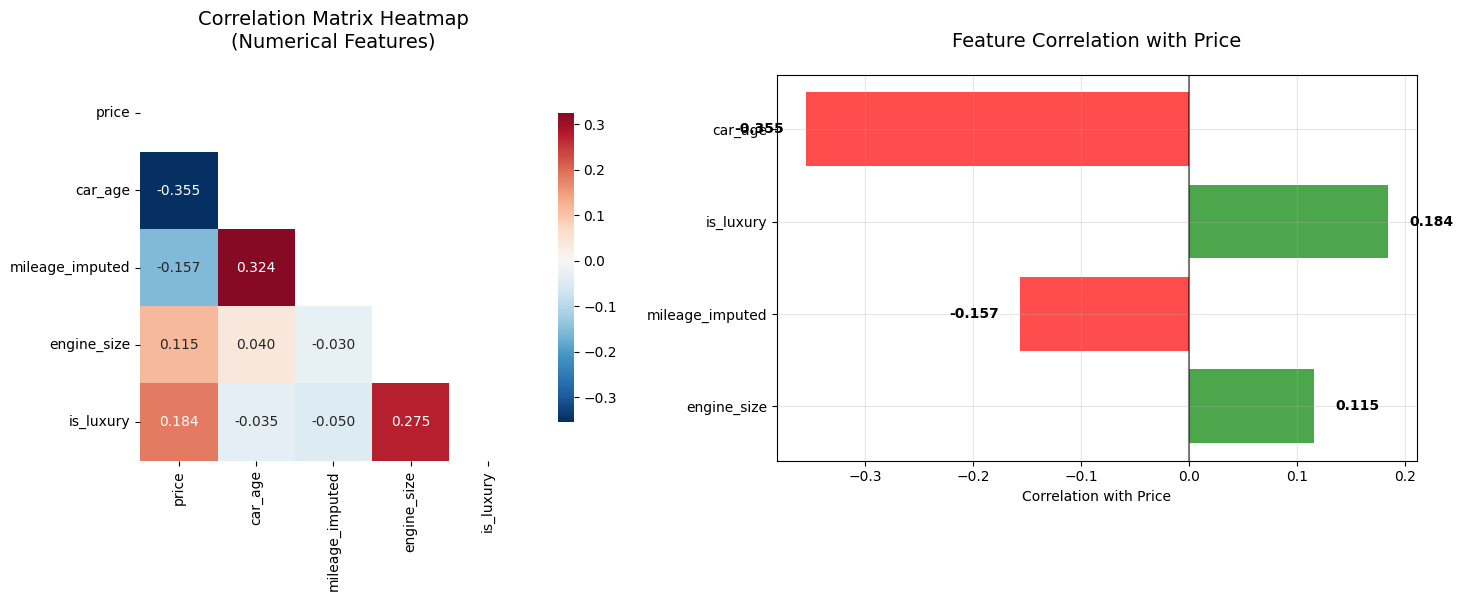


CORRELATION INSIGHTS
🔍 Strong correlations with price (|r| > 0.3):
   • car_age: -0.355 (moderate negatively correlated)

📊 Moderate correlations with price (0.1 < |r| ≤ 0.3):
   • engine_size: 0.115 (weakly positively correlated)
   • mileage_imputed: -0.157 (weakly negatively correlated)
   • is_luxury: 0.184 (weakly positively correlated)

⚠️  MULTICOLLINEARITY CHECK:
Features with high correlation between each other (|r| > 0.7):
   No high multicollinearity detected (all |r| ≤ 0.7)

📈 CORRELATION SUMMARY:
   • Strongest positive correlation: is_luxury (0.184)
   • Strongest negative correlation: car_age (-0.355)
   • Average absolute correlation: 0.203

💡 RECOMMENDATIONS:
   • Car age shows expected negative correlation with price
   • Mileage shows expected negative correlation with price


In [28]:
# Get all numerical features including the target variable
numerical_cols_with_target = ['price', 'car_age', 'mileage_imputed', 'engine_size', 'is_luxury']

# Remove engine_size if it has too many missing values
if df_processed['engine_size'].isna().sum() / len(df_processed) > 0.5:
    numerical_cols_with_target.remove('engine_size')
    print("Note: Removed engine_size from correlation analysis due to too many missing values")

# Calculate correlation matrix
correlation_matrix = df_processed[numerical_cols_with_target].corr()

print("Correlation Matrix:")
display(correlation_matrix.round(4))

# Create visualization
fig1, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Correlation Heatmap
ax1 = axes[0]
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            cmap='RdBu_r', 
            center=0,
            square=True, 
            fmt='.3f',
            cbar_kws={"shrink": .8},
            ax=ax1)
ax1.set_title('Correlation Matrix Heatmap\n(Numerical Features)', fontsize=14, pad=20)

# 2. Correlation with Target Variable (Price)
ax2 = axes[1]
price_correlations = correlation_matrix['price'].drop('price').sort_values(key=abs, ascending=True)
colors = ['red' if x < 0 else 'green' for x in price_correlations.values]
bars = ax2.barh(range(len(price_correlations)), price_correlations.values, color=colors, alpha=0.7)
ax2.set_yticks(range(len(price_correlations)))
ax2.set_yticklabels(price_correlations.index)
ax2.set_xlabel('Correlation with Price')
ax2.set_title('Feature Correlation with Price', fontsize=14, pad=20)
ax2.grid(True, alpha=0.3)
ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

# Add correlation values on bars
for i, (bar, corr) in enumerate(zip(bars, price_correlations.values)):
    ax2.text(corr + (0.02 if corr > 0 else -0.02), i, f'{corr:.3f}', 
             va='center', ha='left' if corr > 0 else 'right', fontweight='bold')

plt.tight_layout()
plt.show()

# Detailed correlation analysis
print("\n" + "="*30)
print("CORRELATION INSIGHTS")
print("="*30)

# Strong correlations with price
strong_correlations = price_correlations[abs(price_correlations) > 0.3]
if len(strong_correlations) > 0:
    print("🔍 Strong correlations with price (|r| > 0.3):")
    for feature, corr in strong_correlations.items():
        direction = "positively" if corr > 0 else "negatively"
        strength = "very strong" if abs(corr) > 0.7 else "strong" if abs(corr) > 0.5 else "moderate"
        print(f"   • {feature}: {corr:.3f} ({strength} {direction} correlated)")
else:
    print("No strong correlations (|r| > 0.3) found with price")

# Moderate correlations
moderate_correlations = price_correlations[(abs(price_correlations) > 0.1) & (abs(price_correlations) <= 0.3)]
if len(moderate_correlations) > 0:
    print(f"\n📊 Moderate correlations with price (0.1 < |r| ≤ 0.3):")
    for feature, corr in moderate_correlations.items():
        direction = "positively" if corr > 0 else "negatively"
        print(f"   • {feature}: {corr:.3f} (weakly {direction} correlated)")

# Feature multicollinearity check
print(f"\n⚠️  MULTICOLLINEARITY CHECK:")
print("Features with high correlation between each other (|r| > 0.7):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_val = correlation_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            feature1 = correlation_matrix.columns[i]
            feature2 = correlation_matrix.columns[j]
            if feature1 != 'price' and feature2 != 'price':  # Exclude price correlations
                high_corr_pairs.append((feature1, feature2, corr_val))

if high_corr_pairs:
    for feat1, feat2, corr in high_corr_pairs:
        print(f"   • {feat1} ↔ {feat2}: {corr:.3f}")
    print("   Consider removing one feature from highly correlated pairs to reduce multicollinearity")
else:
    print("   No high multicollinearity detected (all |r| ≤ 0.7)")

# Summary statistics for interpretation
print(f"\n📈 CORRELATION SUMMARY:")
max_positive = price_correlations.max()
max_negative = price_correlations.min()
print(f"   • Strongest positive correlation: {price_correlations.idxmax()} ({max_positive:.3f})")
print(f"   • Strongest negative correlation: {price_correlations.idxmin()} ({max_negative:.3f})")
print(f"   • Average absolute correlation: {abs(price_correlations).mean():.3f}")

# Recommendations based on correlations
print(f"\n💡 RECOMMENDATIONS:")
if abs(max_positive) < 0.3 and abs(max_negative) < 0.3:
    print("   • Low correlations suggest need for feature engineering or non-linear models")
    print("   • Consider polynomial features or interaction terms")
if len(high_corr_pairs) > 0:
    print("   • Remove highly correlated features to improve model stability")
if 'car_age' in price_correlations and price_correlations['car_age'] < -0.2:
    print("   • Car age shows expected negative correlation with price")
if 'mileage_imputed' in price_correlations and price_correlations['mileage_imputed'] < -0.1:
    print("   • Mileage shows expected negative correlation with price")

In [30]:
outdir = "../outputs"

outpath = os.path.join(outdir, "correlation_matrix.png")

# you can choose dpi, format, etc.
fig1.savefig(outpath, dpi=300, format="png", bbox_inches="tight")

In [9]:
numerical_features = ['car_age', 'mileage_imputed', 'engine_size', 'is_luxury']
categorical_features = ['transmission', 'condition', 'make', 'model', 'engine_info', 'color']

# Remove engine_size from numerical if too many missing values
if df_processed['engine_size'].isna().sum() / len(df_processed) > 0.5:
    numerical_features.remove('engine_size')
    print("Removed engine_size due to too many missing values")

# Prepare X and y
X = df_processed[numerical_features + categorical_features].copy()
y = df_processed['price'].copy()

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nNumerical features: {numerical_features}")
print(f"Categorical features: {categorical_features}")

Features shape: (15364, 10)
Target shape: (15364,)

Numerical features: ['car_age', 'mileage_imputed', 'engine_size', 'is_luxury']
Categorical features: ['transmission', 'condition', 'make', 'model', 'engine_info', 'color']


In [10]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set size: {X_train.shape[0]} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Check target distribution in train/test
print(f"\nTarget variable distribution:")
print(f"Train - Mean: {y_train.mean():,.0f}, Std: {y_train.std():,.0f}")
print(f"Test  - Mean: {y_test.mean():,.0f}, Std: {y_test.std():,.0f}")

Training set size: 12291 samples (80.0%)
Test set size: 3073 samples (20.0%)

Target variable distribution:
Train - Mean: 2,562,567, Std: 2,626,735
Test  - Mean: 2,603,689, Std: 2,653,178


In [11]:
# Create preprocessing pipeline
print("Creating preprocessing pipeline...")

# Numerical preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical preprocessing
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

print("Preprocessing pipeline created successfully!")

# Test the preprocessor to see the output shape
X_train_processed = preprocessor.fit_transform(X_train)
print(f"Processed training data shape: {X_train_processed.shape}")

Creating preprocessing pipeline...
Preprocessing pipeline created successfully!
Processed training data shape: (12291, 802)


In [12]:
# Create pipeline for Linear Regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Train the model
lr_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred_lr = lr_pipeline.predict(X_train)
y_test_pred_lr = lr_pipeline.predict(X_test)

# Calculate metrics
lr_train_mae = mean_absolute_error(y_train, y_train_pred_lr)
lr_test_mae = mean_absolute_error(y_test, y_test_pred_lr)
lr_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
lr_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
lr_train_r2 = r2_score(y_train, y_train_pred_lr)
lr_test_r2 = r2_score(y_test, y_test_pred_lr)

print(f"Linear Regression Results:")
print(f"  Train MAE: {lr_train_mae:,.0f}")
print(f"  Test MAE: {lr_test_mae:,.0f}")
print(f"  Train RMSE: {lr_train_rmse:,.0f}")
print(f"  Test RMSE: {lr_test_rmse:,.0f}")
print(f"  Train R²: {lr_train_r2:.4f}")
print(f"  Test R²: {lr_test_r2:.4f}")

Linear Regression Results:
  Train MAE: 321,116
  Test MAE: 351,887
  Train RMSE: 768,628
  Test RMSE: 989,429
  Train R²: 0.9144
  Test R²: 0.8609


In [13]:
# Create pipeline for Random Forest
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        max_depth=20,
        min_samples_split=5,
        min_samples_leaf=2,
        n_jobs=-1
    ))
])

# Train the model
rf_pipeline.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_pipeline.predict(X_train)
y_test_pred_rf = rf_pipeline.predict(X_test)

# Calculate metrics
rf_train_mae = mean_absolute_error(y_train, y_train_pred_rf)
rf_test_mae = mean_absolute_error(y_test, y_test_pred_rf)
rf_train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_rf))
rf_train_r2 = r2_score(y_train, y_train_pred_rf)
rf_test_r2 = r2_score(y_test, y_test_pred_rf)

print(f"Random Forest Results:")
print(f"  Train MAE: {rf_train_mae:,.0f}")
print(f"  Test MAE: {rf_test_mae:,.0f}")
print(f"  Train RMSE: {rf_train_rmse:,.0f}")
print(f"  Test RMSE: {rf_test_rmse:,.0f}")
print(f"  Train R²: {rf_train_r2:.4f}")
print(f"  Test R²: {rf_test_r2:.4f}")

Random Forest Results:
  Train MAE: 96,281
  Test MAE: 157,097
  Train RMSE: 357,484
  Test RMSE: 688,123
  Train R²: 0.9815
  Test R²: 0.9327


In [14]:
# Create results comparison
results_comparison = pd.DataFrame({
    'Linear Regression': [lr_train_mae, lr_test_mae, lr_train_rmse, lr_test_rmse, lr_train_r2, lr_test_r2],
    'Random Forest': [rf_train_mae, rf_test_mae, rf_train_rmse, rf_test_rmse, rf_train_r2, rf_test_r2]
}, index=['Train MAE', 'Test MAE', 'Train RMSE', 'Test RMSE', 'Train R²', 'Test R²'])

print("Results Comparison:")
display(results_comparison.round(4))

# Determine best model
best_model_name = 'Random Forest' if rf_test_mae < lr_test_mae else 'Linear Regression'
print(f"\nBest Model: {best_model_name} (based on Test MAE)")

Results Comparison:


,Linear Regression,Random Forest
Train MAE,321116.3428,96280.8420
Test MAE,351886.9822,157097.3990
Train RMSE,768628.2202,357484.1304
Test RMSE,989428.8425,688122.8292
Train R²,0.9144,0.9815
Test R²,0.8609,0.9327



Best Model: Random Forest (based on Test MAE)


In [15]:
# Feature Importance Analysis (Random Forest)
print("="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get the trained Random Forest model
rf_model = rf_pipeline.named_steps['model']
preprocessor_fitted = rf_pipeline.named_steps['preprocessor']

# Get feature names after preprocessing
feature_names = []

# Add numerical feature names
feature_names.extend(numerical_features)

# Add categorical feature names after one-hot encoding
cat_transformer = preprocessor_fitted.named_transformers_['cat']
if hasattr(cat_transformer.named_steps['onehot'], 'get_feature_names_out'):
    cat_features_encoded = cat_transformer.named_steps['onehot'].get_feature_names_out(categorical_features)
    feature_names.extend(cat_features_encoded)

# Get feature importance
feature_importance = rf_model.feature_importances_

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

print("Top 15 Most Important Features:")
display(importance_df.head(15))

print("\n" + "="*30)
print("TOP 5 FEATURES INFLUENCING PRICE:")
print("="*30)
top_5_features = importance_df.head(5)
for idx, (_, row) in enumerate(top_5_features.iterrows(), 1):
    print(f"{idx}. {row['Feature']}: {row['Importance']:.4f}")

FEATURE IMPORTANCE ANALYSIS
Top 15 Most Important Features:


,Feature,Importance
2,engine_size,0.321056
0,car_age,0.296311
121,model_Land Cruiser,0.080847
755,engine_info_Unknown,0.061581
128,model_Lx,0.060372
1,mileage_imputed,0.024459
98,model_G-Class,0.024273
26,make_Mercedes‑Benz,0.014778
177,model_Rover Range Rover Sport,0.012634
213,model_X5,0.012558



TOP 5 FEATURES INFLUENCING PRICE:
1. engine_size: 0.3211
2. car_age: 0.2963
3. model_Land Cruiser: 0.0808
4. engine_info_Unknown: 0.0616
5. model_Lx: 0.0604


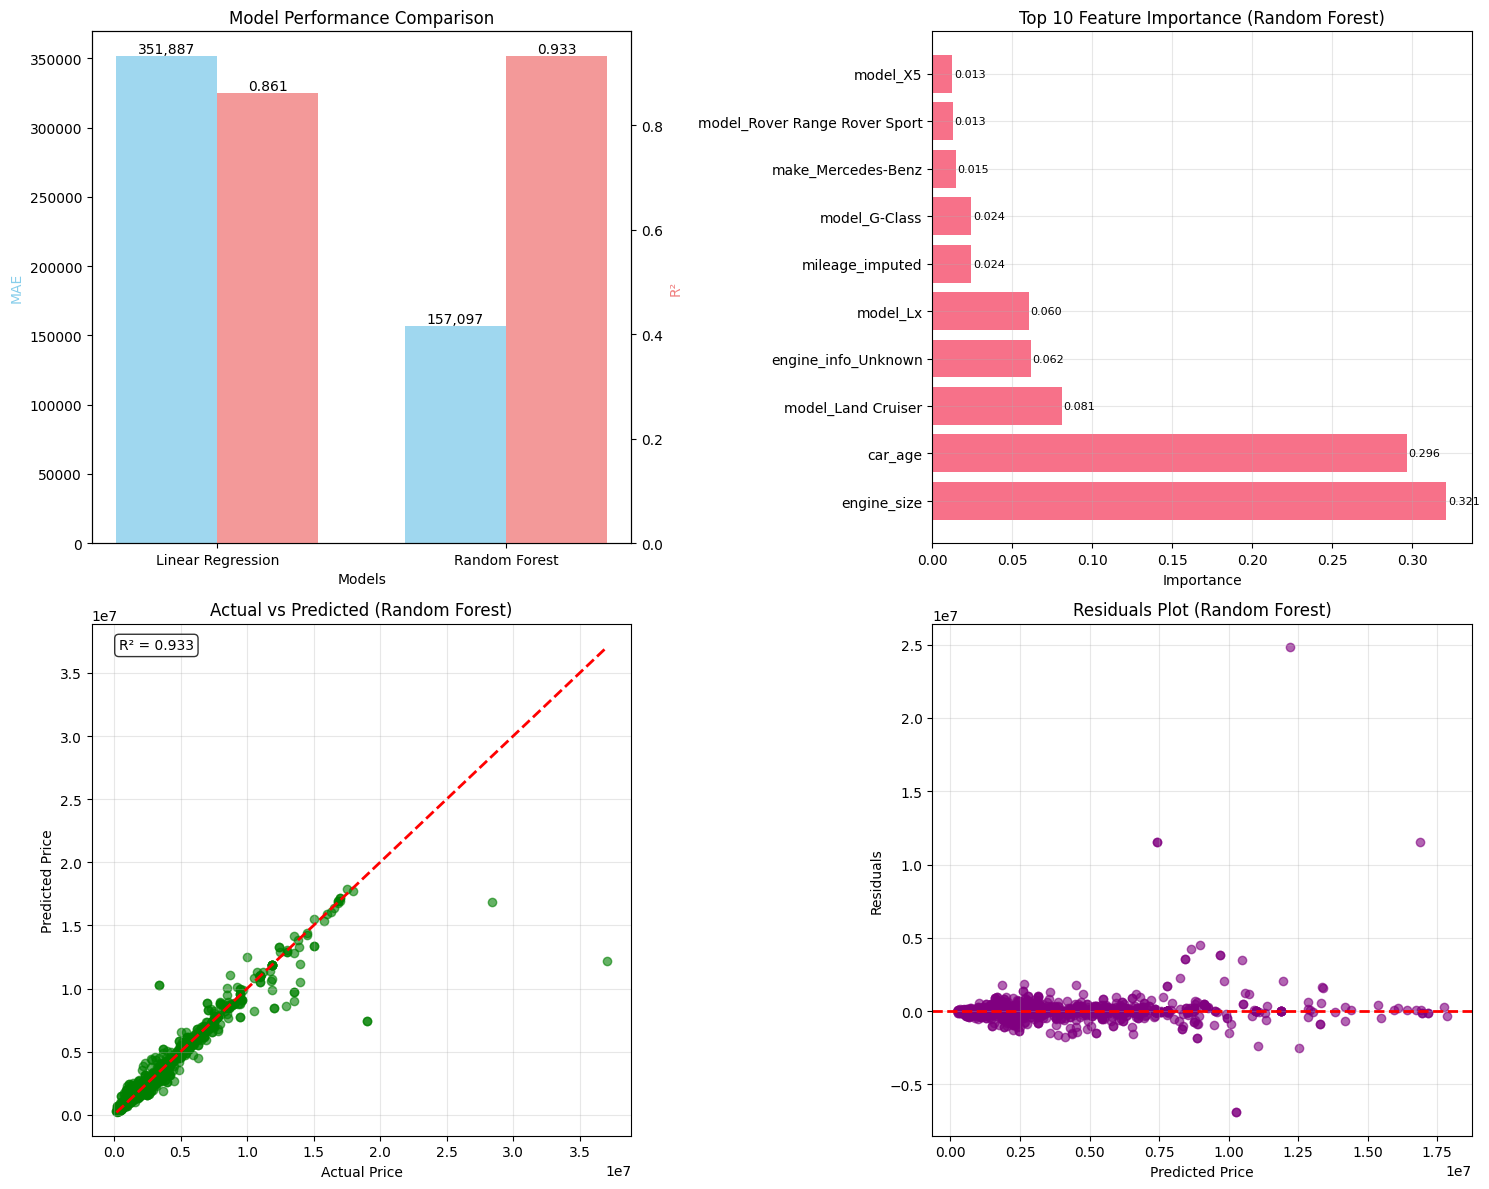

In [31]:
# Model Performance Visualizations
fig2, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Model Performance Comparison
ax1 = axes[0, 0]
models = ['Linear Regression', 'Random Forest']
test_mae_values = [lr_test_mae, rf_test_mae]
test_r2_values = [lr_test_r2, rf_test_r2]

x = np.arange(len(models))
width = 0.35

ax1_twin = ax1.twinx()
bars1 = ax1.bar(x - width/2, test_mae_values, width, label='Test MAE', alpha=0.8, color='skyblue')
bars2 = ax1_twin.bar(x + width/2, test_r2_values, width, label='Test R²', alpha=0.8, color='lightcoral')

ax1.set_xlabel('Models')
ax1.set_ylabel('MAE', color='skyblue')
ax1_twin.set_ylabel('R²', color='lightcoral')
ax1.set_title('Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models)

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}', ha='center', va='bottom')

for bar in bars2:
    height = bar.get_height()
    ax1_twin.text(bar.get_x() + bar.get_width()/2., height,
                  f'{height:.3f}', ha='center', va='bottom')

# 2. Feature Importance (Top 10)
ax2 = axes[0, 1]
top_10_features = importance_df.head(10)
bars = ax2.barh(range(len(top_10_features)), top_10_features['Importance'])
ax2.set_yticks(range(len(top_10_features)))
ax2.set_yticklabels(top_10_features['Feature'], fontsize=10)
ax2.set_xlabel('Importance')
ax2.set_title('Top 10 Feature Importance (Random Forest)')
ax2.grid(True, alpha=0.3)

# Add value labels
for i, (bar, importance) in enumerate(zip(bars, top_10_features['Importance'])):
    ax2.text(importance + 0.001, i, f'{importance:.3f}', 
             va='center', fontsize=8)

# 3. Actual vs Predicted (Random Forest)
ax3 = axes[1, 0]
ax3.scatter(y_test, y_test_pred_rf, alpha=0.6, color='green')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax3.set_xlabel('Actual Price')
ax3.set_ylabel('Predicted Price')
ax3.set_title('Actual vs Predicted (Random Forest)')
ax3.grid(True, alpha=0.3)

# Add R² score to the plot
ax3.text(0.05, 0.95, f'R² = {rf_test_r2:.3f}', transform=ax3.transAxes, 
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# 4. Residuals Plot
ax4 = axes[1, 1]
residuals_rf = y_test - y_test_pred_rf
ax4.scatter(y_test_pred_rf, residuals_rf, alpha=0.6, color='purple')
ax4.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax4.set_xlabel('Predicted Price')
ax4.set_ylabel('Residuals')
ax4.set_title('Residuals Plot (Random Forest)')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show();

In [32]:
outdir = "../outputs"

outpath = os.path.join(outdir, "model_performance_comparison.png")

# you can choose dpi, format, etc.
fig2.savefig(outpath, dpi=300, format="png", bbox_inches="tight")

In [17]:
# Additional Analysis
print("="*50)
print("ADDITIONAL ANALYSIS")
print("="*50)

# Prediction accuracy by price range
def analyze_by_price_range(y_true, y_pred, ranges):
    results = []
    for i, (low, high) in enumerate(ranges):
        mask = (y_true >= low) & (y_true < high)
        if mask.sum() > 0:
            mae = mean_absolute_error(y_true[mask], y_pred[mask])
            r2 = r2_score(y_true[mask], y_pred[mask])
            count = mask.sum()
            results.append({
                'Price Range': f'{low:,.0f} - {high:,.0f}',
                'Count': count,
                'MAE': mae,
                'R²': r2
            })
    return pd.DataFrame(results)

# Define price ranges
price_ranges = [
    (0, 1000000),
    (1000000, 3000000),
    (3000000, 6000000),
    (6000000, float('inf'))
]

# Analyze Random Forest performance by price range
range_analysis = analyze_by_price_range(y_test.values, y_test_pred_rf, price_ranges)
print("Random Forest Performance by Price Range:")
display(range_analysis)

# Feature correlation with target
print(f"\nNumerical Features Correlation with Price:")
numerical_data = df_processed[numerical_features + ['price']].corr()['price'].sort_values(ascending=False)
print(numerical_data.drop('price'))

ADDITIONAL ANALYSIS
Random Forest Performance by Price Range:


,Price Range,Count,MAE,R²
0,"0 - 1,000,000",930,45250.571818,0.548159
1,"1,000,000 - 3,000,000",1365,110243.685896,0.816565
2,"3,000,000 - 6,000,000",481,244476.077944,0.586866
3,"6,000,000 - inf",297,581150.338696,0.666603



Numerical Features Correlation with Price:
is_luxury          0.183572
engine_size        0.115402
mileage_imputed   -0.156756
car_age           -0.355105
Name: price, dtype: float64


In [18]:
# Best model summary
best_model = 'Random Forest' if rf_test_mae < lr_test_mae else 'Linear Regression'
best_mae = min(rf_test_mae, lr_test_mae)
best_r2 = rf_test_r2 if rf_test_mae < lr_test_mae else lr_test_r2

print(f"🏆 BEST MODEL: {best_model}")
print(f"   • Test MAE: {best_mae:,.0f} (Average prediction error)")
print(f"   • Test R²: {best_r2:.4f} (Explains {best_r2*100:.1f}% of price variance)")

# Performance interpretation
if best_r2 > 0.8:
    performance = "Excellent"
elif best_r2 > 0.6:
    performance = "Good"
elif best_r2 > 0.4:
    performance = "Moderate"
else:
    performance = "Poor"

print(f"   • Model Performance: {performance}")

print(f"\n🔍 TOP 5 PRICE INFLUENCING FEATURES:")
for i, (_, row) in enumerate(top_5_features.iterrows(), 1):
    feature_clean = row['Feature'].replace('_', ' ').title()
    print(f"   {i}. {feature_clean} (Importance: {row['Importance']:.4f})")

print(f"\n💡 KEY INSIGHTS:")
# Analyze top features
top_feature = top_5_features.iloc[0]['Feature']
if 'make' in top_feature.lower():
    print(f"   • Car brand is the strongest price predictor")
elif 'age' in top_feature.lower():
    print(f"   • Car age is the strongest price predictor")
elif 'mileage' in top_feature.lower():
    print(f"   • Mileage is the strongest price predictor")

print(f"   • Model can predict prices within ±{best_mae:,.0f} on average")
print(f"   • Random Forest {'outperformed' if rf_test_mae < lr_test_mae else 'was outperformed by'} Linear Regression")

print(f"\n🚀 RECOMMENDATIONS FOR IMPROVEMENT:")
print(f"   1. Feature Engineering:")
print(f"      - Create luxury brand indicators")
print(f"      - Extract more details from engine_info")
print(f"      - Add make-model interaction features")
print(f"   2. Advanced Models:")
print(f"      - Try XGBoost or LightGBM")
print(f"      - Implement ensemble methods")
print(f"   3. Data Collection:")
print(f"      - Gather more recent data")
print(f"      - Add features like fuel type, body type")
print(f"   4. Model Optimization:")
print(f"      - Hyperparameter tuning")
print(f"      - Cross-validation")

print(f"\n✅ MODELING TASKS COMPLETED:")
print(f"   ✓ Dataset split into train/test sets")
print(f"   ✓ Trained regression models (Linear & Random Forest)")
print(f"   ✓ Evaluated using MAE, RMSE, and R²")
print(f"   ✓ Identified top 5 price-influencing features")

🏆 BEST MODEL: Random Forest
   • Test MAE: 157,097 (Average prediction error)
   • Test R²: 0.9327 (Explains 93.3% of price variance)
   • Model Performance: Excellent

🔍 TOP 5 PRICE INFLUENCING FEATURES:
   1. Engine Size (Importance: 0.3211)
   2. Car Age (Importance: 0.2963)
   3. Model Land Cruiser (Importance: 0.0808)
   4. Engine Info Unknown (Importance: 0.0616)
   5. Model Lx (Importance: 0.0604)

💡 KEY INSIGHTS:
   • Model can predict prices within ±157,097 on average
   • Random Forest outperformed Linear Regression

🚀 RECOMMENDATIONS FOR IMPROVEMENT:
   1. Feature Engineering:
      - Create luxury brand indicators
      - Extract more details from engine_info
      - Add make-model interaction features
   2. Advanced Models:
      - Try XGBoost or LightGBM
      - Implement ensemble methods
   3. Data Collection:
      - Gather more recent data
      - Add features like fuel type, body type
   4. Model Optimization:
      - Hyperparameter tuning
      - Cross-validation

✅ 